In [1]:
import pandas as pd
import numpy as np
import sklearn as sk 
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\Varshith\Desktop\homeworks\Emory_HW\ML\hw3\loan_default.csv')

In [3]:
df['term'] = df['term'].apply(lambda x: 1 if x == ' 60 months' else 0)

grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1 }
df['grade'] = df['grade'].replace(grade_mapping)
df['grade'] = df['grade'].astype(int)

df['emp_length'] = df['emp_length'].str.replace('<', '')
df['emp_length'] = df['emp_length'].str.replace(' years', '')
df['emp_length'] = df['emp_length'].str.replace(' year', '')
df['emp_length'] = df['emp_length'].str.replace('n/a', '')
df['emp_length'] = df['emp_length'].str.replace(' ', '')
df['emp_length'] = df['emp_length'].str.replace('+', '')
df['emp_length'] = df['emp_length'].apply(lambda x: 10 if x == "" else x)
df['emp_length'] = df['emp_length'].fillna(0)
df['emp_length'] = df['emp_length'].astype(int)

df['home_ownership'] = df['home_ownership'].astype(str)
df['home_ownership'] = df['home_ownership'].apply(lambda x: 1 if x in ['OWN', 'MORTGAGE'] else 0)
df['home_ownership'] = df['home_ownership'].astype(int)

df['verification_status'] = df['verification_status'].apply(lambda x: 1 if x in ['Verified', 'Source Verified'] else 0)

df['purpose'] = df['purpose'].astype(str)
df['purpose'] = df['purpose'].replace({
    'home_improvement': 1, 'other': 1, 'moving': 1, 'vacation': 1,
    'major_purchase': 1, 'small_business': 1, 'car': 1, 'medical': 1,
    'house': 1, 'renewable_energy': 1, 'wedding': 1
})

df['purpose'] = df['purpose'].apply(lambda x: 1 if x == 1 else 0)
df['purpose'] = df['purpose'].astype(int)

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%d-%m-%Y').dt.year

C:\Users\Varshith\AppData\Local\Temp\ipykernel_26072\1990223025.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['emp_length'] = df['emp_length'].str.replace('+', '')


In [4]:
df = df.drop(["earliest_cr_line"], axis = 1)
# df = df.sample(frac = 1)

In [5]:
train, test = train_test_split(df, test_size=0.15, random_state=42) 
train, val = train_test_split(train, test_size=0.15, random_state=42)
type(train)

pandas.core.frame.DataFrame

In [6]:
def compute_correlation(x, corrtype):
    x1 = pd.DataFrame(x)
    coef_matrix = x1.corr(method= corrtype)
    return np.array(coef_matrix)

In [7]:
corr_matrix_train = df.corr(method='kendall')
matrix_train=corr_matrix_train["class"].sort_values(ascending=False)
print(matrix_train)

class                         1.000000
recoveries                    0.582274
int_rate                      0.219313
term                          0.150743
dti                           0.132389
revol_util                    0.091166
verification_status           0.080341
inq_last_6mths                0.066141
loan_amnt                     0.034826
delinq_2yrs                   0.029103
installment                   0.029060
acc_now_delinq                0.021266
tot_coll_amt                  0.009997
revol_bal                     0.009458
collections_12_mths_ex_med    0.009239
open_acc                      0.004161
pub_rec                      -0.007845
purpose                      -0.031065
total_acc                    -0.045733
tot_cur_bal                  -0.047766
emp_length                   -0.051849
total_rev_hi_lim             -0.056563
home_ownership               -0.058323
id                           -0.059416
annual_inc                   -0.116646
grade                    

In [8]:
X = train.drop(['class'],axis=1)
x = train.drop(['class'], axis=1).values
y = train['class'].values
x_val = val.drop(['class'], axis=1).values
y_val = val['class'].values
x_test = test.drop(['class'], axis=1).values
y_test = test['class'].values

In [9]:
k =compute_correlation(train.values, 'kendall')
print(k)

[[ 1.00000000e+00 -2.56520864e-03  4.72959347e-02 -6.61432235e-02
  -2.18599738e-02 -1.31153005e-02  3.39554585e-03 -1.28673042e-02
   2.81392960e-02  1.52152022e-02  2.71607181e-02  9.27900489e-03
   3.39014327e-02 -9.90332667e-03  2.32952522e-02  8.41442716e-02
  -4.54915579e-02 -8.05928632e-02  2.84387236e-02 -8.68501495e-02
   2.37241187e-02  3.81163977e-02  3.88288043e-02  8.64811185e-03
   3.49639827e-03 -4.53262209e-02]
 [-2.56520864e-03  1.00000000e+00  3.54668284e-01  9.37662296e-02
   8.75933368e-01 -9.61201034e-02  7.09922048e-02  1.20493675e-01
   3.38552993e-01  2.75115711e-01 -1.81285695e-01  3.72621839e-02
   5.12154510e-03  2.86865003e-02  1.56536120e-01 -1.04905671e-01
   3.53751618e-01  9.02467370e-02  1.55357804e-01  5.54237531e-02
  -4.77735689e-02  6.48322878e-03 -4.33587510e-02  2.33706731e-01
   3.05148827e-01  4.44914446e-02]
 [ 4.72959347e-02  3.54668284e-01  1.00000000e+00  3.66877413e-01
   2.00224469e-01 -4.08122949e-01  5.30727577e-02  7.80769913e-02
   1.2

In [31]:
def rank_correlation(x, y):
    corrs = []
    for i in range(x.shape[1]):
        corr,_ = pearsonr(x[:,i], y)
        corrs.append(corr)
    rank = np.argsort(np.abs(corrs))[::-1]
    return rank

In [32]:
rank_correlation(x,y)

array([19,  3,  5,  2, 11,  8, 17,  9, 13, 24, 23,  0,  1,  6,  7, 10, 18,
       12,  4, 16, 15, 22, 21, 14, 20], dtype=int64)

In [13]:
X

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
983,683915,12000,1,13.99,279.16,5,10,0,85000.0,1,...,0,155,1.1,34,0.00,0,0,0,322884,14500.0
2798,242107,7075,0,17.86,255.29,4,0,0,16906.8,1,...,0,2519,90.0,69,0.00,0,0,0,7937,2800.0
597,757145,19000,0,6.39,581.39,7,1,1,135000.0,1,...,0,39764,42.8,26,0.00,0,0,0,577189,93000.0
1977,145916,4600,0,19.05,168.74,4,3,1,150000.0,0,...,0,664,11.3,11,0.00,0,0,0,7409,5900.0
1376,759925,34675,0,6.68,1065.60,7,10,1,95000.0,1,...,0,7386,15.8,18,0.00,0,0,0,50279,46700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,121137,7200,0,10.64,234.50,6,4,1,67000.0,1,...,0,6475,37.6,11,902.27,0,0,0,333188,17200.0
2431,86891,16000,0,12.99,539.03,6,4,0,69900.0,0,...,0,14729,29.8,17,2577.28,0,0,0,15177,49400.0
818,143861,11625,0,21.00,437.98,3,10,1,96000.0,1,...,0,0,0.0,8,0.00,0,0,0,9873,6000.0
1042,188517,20050,1,22.95,564.65,2,1,1,46000.0,1,...,0,25846,77.2,48,0.00,0,0,0,161899,33474.0


In [14]:
from sklearn.feature_selection import mutual_info_classif

def rank_mutual(x, y):
    mutual_info = mutual_info_classif(x, y)
    rank = np.argsort(mutual_info)[::-1]
    return rank

In [15]:
rank_mutual(x,y)



array([19,  5,  3,  2, 21, 13, 17,  6,  4, 18, 11,  8, 12, 20,  1, 16,  0,
       22,  7,  9, 10, 23, 14, 15, 24], dtype=int64)

In [16]:
x_val

array([[7.64032e+05, 3.75000e+03, 0.00000e+00, ..., 0.00000e+00,
        1.13280e+04, 1.90000e+04],
       [1.91085e+05, 1.20000e+04, 0.00000e+00, ..., 0.00000e+00,
        1.05210e+04, 2.29000e+04],
       [3.50611e+05, 2.00000e+04, 1.00000e+00, ..., 0.00000e+00,
        1.85031e+05, 9.20000e+03],
       ...,
       [1.50066e+05, 9.60000e+03, 0.00000e+00, ..., 0.00000e+00,
        2.37141e+05, 3.54000e+04],
       [3.26606e+05, 2.50000e+03, 0.00000e+00, ..., 0.00000e+00,
        2.94190e+04, 1.41000e+04],
       [8.42240e+04, 2.00000e+04, 1.00000e+00, ..., 7.80000e+01,
        3.89790e+04, 9.10000e+03]])

In [17]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def tune_dt(x, y, dparams, lsparams):

        dt = DecisionTreeClassifier()
        param_grid = {
            'max_depth': dparams,
            'min_samples_leaf': lsparams
        }

        grid_search = GridSearchCV(dt, param_grid, scoring='roc_auc', cv=5)
        grid_search.fit(x, y)
        auc_scores = grid_search.cv_results_['mean_test_score'].reshape(len(depths), len(min_leaf_samples))
        mean_test_auc = grid_search.cv_results_['mean_test_score']  # Mean AUC scores for each parameter combination
        params = grid_search.cv_results_['params']  # Parameters corresponding to each AUC score
        best_depth = grid_search.best_params_['max_depth']
        best_leaf_samples = grid_search.best_params_['min_samples_leaf']
        best_auc = grid_search.best_score_
        result_dict = {
            "best-depth": best_depth,
            "best-leaf-samples": best_leaf_samples,
            "best-auc": best_auc,
            "auc-scores": auc_scores
        }

        return result_dict

In [18]:
depths = [2, 3, 5, 8, 10]
min_leaf_samples = [3, 5, 10, 15, 20] 
result = tune_dt(x_val, y_val, depths, min_leaf_samples)
auc_values = result['auc-scores']
result

{'best-depth': 10,
 'best-leaf-samples': 20,
 'best-auc': 0.8039166666666668,
 'auc-scores': array([[0.76794444, 0.76794444, 0.76794444, 0.76794444, 0.76794444],
        [0.78060417, 0.78060417, 0.78010417, 0.78435417, 0.78627083],
        [0.77852431, 0.76403819, 0.77095139, 0.78729861, 0.79868403],
        [0.73971528, 0.76178125, 0.78062847, 0.79586111, 0.80391667],
        [0.75990625, 0.74504167, 0.77454514, 0.789625  , 0.80391667]])}

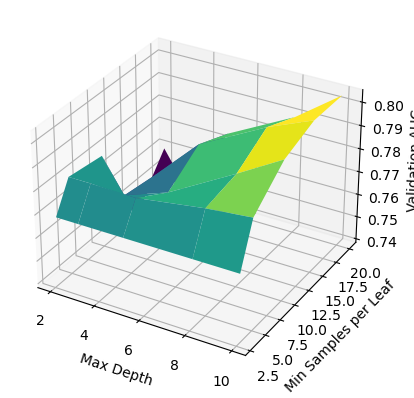

In [19]:
from mpl_toolkits.mplot3d import Axes3D
max_depth_grid, min_samples_leaf_grid = np.meshgrid(depths, min_leaf_samples)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(max_depth_grid, min_samples_leaf_grid, auc_values, cmap='viridis')

# Label axes
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples per Leaf')
ax.set_zlabel('Validation AUC')

# Show the plot
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score
dt = DecisionTreeClassifier(max_depth=result['best-depth'], min_samples_leaf=result['best-leaf-samples'])
dt.fit(x, y) 
y_pred = dt.predict(x_test)
auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("AUC: ", auc, "F1: ", f1, "F2: ", f2)
X

AUC:  0.7485079575596817 F1:  0.6559139784946235 F2:  0.5711610486891388


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
983,683915,12000,1,13.99,279.16,5,10,0,85000.0,1,...,0,155,1.1,34,0.00,0,0,0,322884,14500.0
2798,242107,7075,0,17.86,255.29,4,0,0,16906.8,1,...,0,2519,90.0,69,0.00,0,0,0,7937,2800.0
597,757145,19000,0,6.39,581.39,7,1,1,135000.0,1,...,0,39764,42.8,26,0.00,0,0,0,577189,93000.0
1977,145916,4600,0,19.05,168.74,4,3,1,150000.0,0,...,0,664,11.3,11,0.00,0,0,0,7409,5900.0
1376,759925,34675,0,6.68,1065.60,7,10,1,95000.0,1,...,0,7386,15.8,18,0.00,0,0,0,50279,46700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,121137,7200,0,10.64,234.50,6,4,1,67000.0,1,...,0,6475,37.6,11,902.27,0,0,0,333188,17200.0
2431,86891,16000,0,12.99,539.03,6,4,0,69900.0,0,...,0,14729,29.8,17,2577.28,0,0,0,15177,49400.0
818,143861,11625,0,21.00,437.98,3,10,1,96000.0,1,...,0,0,0.0,8,0.00,0,0,0,9873,6000.0
1042,188517,20050,1,22.95,564.65,2,1,1,46000.0,1,...,0,25846,77.2,48,0.00,0,0,0,161899,33474.0


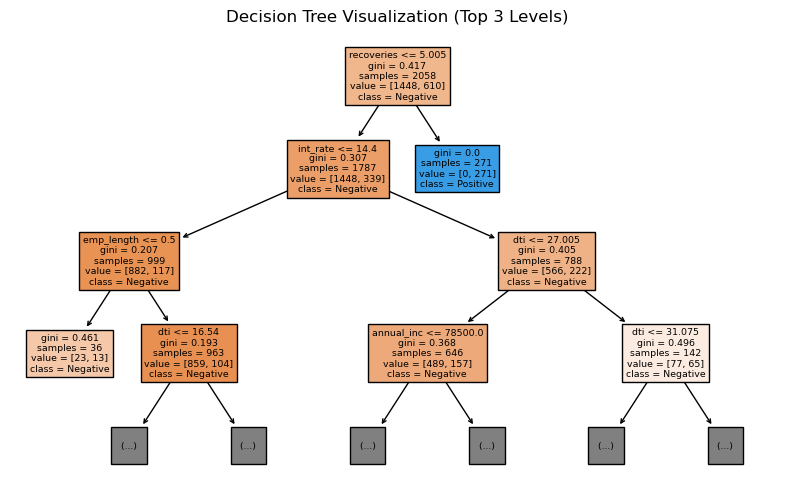

In [21]:
plt.figure(figsize=(10, 6))
feature_names = X.columns.tolist()
plot_tree(dt, filled=True, feature_names=feature_names, class_names=['Negative', 'Positive'], max_depth= 3)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

In [38]:
# x1 = X[['delinq_2yrs','inq_last_6mths','int_rate','loan_amnt', 'revol_util', 'term','dti',
#              'open_acc', 'grade', 'home_ownership']].values
x1 = X[['recoveries', 'int_rate', 'grade', 'term', 'dti', 'annual_inc', 'revol_util', 'verification_status'
        ,'inq_last_6mths', 'total_rev_hi_lim']].values
# x2 = X[['int_rate', 'loan_amnt', 'term', 'emp_length', 'open_acc']].values
x2 = X[['recoveries', 'int_rate', 'grade', 'term', 'acc_now_delinq', 'inq_last_6mths', 'revol_util']].values
result1 = tune_dt(x1, y, depths, min_leaf_samples)
print(result1)
result2 = tune_dt(x2, y, depths, min_leaf_samples)
print(result2)
result3 = tune_dt(x,y,depths, min_leaf_samples)
print(result3)
dt1 = DecisionTreeClassifier(max_depth = result1['best-depth'], min_samples_leaf = result1['best-leaf-samples'])
dt2 = DecisionTreeClassifier(max_depth = result2['best-depth'], min_samples_leaf = result2['best-leaf-samples'])
dt3 = DecisionTreeClassifier(max_depth = result3['best-depth'], min_samples_leaf = result3['best-leaf-samples'])

{'best-depth': 5, 'best-leaf-samples': 15, 'best-auc': 0.8068459787067155, 'auc-scores': array([[0.79402622, 0.79402622, 0.79402622, 0.79402622, 0.79402622],
       [0.80674676, 0.80674676, 0.80674676, 0.80415728, 0.80415728],
       [0.79618103, 0.79867205, 0.80637004, 0.80684598, 0.80677926],
       [0.77641677, 0.77562658, 0.78796796, 0.79520018, 0.79831202],
       [0.74709599, 0.76060498, 0.78382074, 0.78416226, 0.795888  ]])}
{'best-depth': 8, 'best-leaf-samples': 20, 'best-auc': 0.7979846295582709, 'auc-scores': array([[0.79402622, 0.79402622, 0.79402622, 0.79402622, 0.79402622],
       [0.79672914, 0.79672914, 0.79672914, 0.79672914, 0.79672914],
       [0.79059727, 0.79053663, 0.79138681, 0.79551023, 0.79546397],
       [0.78382195, 0.78700436, 0.78930589, 0.79675885, 0.79798463],
       [0.77631639, 0.77648755, 0.77954542, 0.79178154, 0.79524267]])}
{'best-depth': 3, 'best-leaf-samples': 3, 'best-auc': 0.8053681531802027, 'auc-scores': array([[0.79402622, 0.79402622, 0.794026

In [39]:
a = dt1.fit(x, y) 
y_pred = a.predict(x_test)
auc1 = roc_auc_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
f2_1 = fbeta_score(y_test, y_pred, beta=2)
print("AUC: ", auc1, "F1: ", f1_1, "F2: ", f2_1)

AUC:  0.7501105216622459 F1:  0.6594594594594594 F2:  0.572232645403377


In [40]:
b= dt2.fit(x, y) 
y_pred1 = b.predict(x_test)
auc_2 = roc_auc_score(y_test, y_pred1)
f1_2 = f1_score(y_test, y_pred1)
f2_2 = fbeta_score(y_test, y_pred1, beta=2)
print("AUC: ", auc_2, "F1: ", f1_2, "F2: ", f2_2)

AUC:  0.7469053934571176 F1:  0.6524064171122995 F2:  0.5700934579439252


In [41]:
c= dt3.fit(x, y) 
y_pred2 = c.predict(x_test)
auc_3 = roc_auc_score(y_test, y_pred2)
f1_3 = f1_score(y_test, y_pred2)
f2_3 = fbeta_score(y_test, y_pred2, beta=2)
print("AUC: ", auc_3, "F1: ", f1_3, "F2: ", f2_3)

AUC:  0.7456896551724138 F1:  0.6589595375722543 F2:  0.5470249520153551


In [30]:
dt1

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)